<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/%ED%95%AD%EB%A1%9C_%ED%91%9C%EC%A7%80_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9D%B4%EC%83%81_%ED%83%90%EC%A7%80_Recurrent_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import pandas as pd # 판다스 호출 
import numpy as np  # 넘파이 호출 
import torch 
import statsmodels.api as sm # statsmodels 호출 
import seaborn as sns # 그래프를 그리기위한 Seaborn 호출 
from statsmodels.tsa.seasonal import seasonal_decompose # 데이터 필터 라이러리 호출 
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataframe = pd.read_csv('./drive/MyDrive/study/tmp_TB_STATUS.csv')
raw_data = dataframe.values
dataframe.head()

,Unnamed: 0,MMAF_CODE,MMSI,COLCT_DT,REG_ANS,COMM_TYPE,LATITUDE,LONGITUDE,INSTALL_DT,LANTERN_STATUS,RACON_STATUS,BATTERY_STATUS,CHARGER_STATUS,SOLAR_STATUS,DATALOGGER_STATUS,SPARE_STATUS,MAIN_VOLT_STATUS,SUB_VOLT_STATUS,SOLAR_VOLT_STATUS,WIND_VOLT_STATUS,WAVE_VOLT_STATUS,CHARGER_VOLT_STATUS,BATTERY_VOLT_STATUS,SPARE_VOLT_STATUS,AIS_CURR_STATUS,LANTERN_CURR_STATUS,DATALOGGER_CURR_STATUS,SPARE_CURR_STATUS,WIND_SPEED_STATUS,WIND_DIRECT_STATUS,AIR_TEMPER_STATUS,HUMIDITY_STATUS,DEW_POINT_STATUS,AIR_PRESSURE_STATUS,HORIZON_VISIBL_STATUS,WATER_LEVEL_STATUS,CURRENT1_STATUS,CURRENT2_STATUS,CURRENT3_STATUS,WAVE_HEIGHT_STATUS,WAVE_DRC_STATUS,SWELL_HEIGHT_STATUS,SWELL_DRC_STATUS,WATER_TEMPER_STATUS,PRECIPI_TYPE_STATUS,SALINITY_STATUS,ICE_STATUS,HEAT_PROSTR_STATUS,HELIOGRAPH_STATUS,OXYGEN_STATUS,OXYGEN_SATUR_STATUS,PH_STATUS,CHLOROPHYLL_STATUS,MUDDINESS_STATUS,PRECIPI_STATUS,CHARGER_CURR_STATUS,DISCHARGER_CURR_STATUS,VTS_ID,BASESTATION_ID,REGIST_USER_NO,REGIST_DT,UPDT_USER_NO,UPDT_DT
0,0,103,994403901,1.998030e+13,NaN,NaN,33.797717,126.322500,NaN,0,0,1,0.0,1.0,0.0,NaN,13.4,NaN,2.0,NaN,NaN,NaN,14.7,0.0,0.26,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.87,NaN,NaN,NaN,NaN,NaN,NaN
1,1,104,994401597,2.014030e+13,NaN,NaN,35.066583,129.130850,NaN,0,2,1,0.0,1.0,0.0,NaN,10.5,NaN,0.0,NaN,NaN,NaN,10.2,0.0,0.16,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.59,NaN,NaN,NaN,NaN,NaN,NaN
2,2,107,994402986,2.014020e+13,NaN,NaN,34.703650,125.837100,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,8.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,107,994402986,2.014020e+13,NaN,NaN,34.703667,125.837117,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,0.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.01,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,4,107,994402986,2.014020e+13,NaN,NaN,34.703667,125.837117,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,0.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN


[[ 0.   0.   0.  ... 13.5 13.3 13.3]
 [11.6 14.4  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ... 13.2 13.1  9.1]
 ...
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ... 13.8 13.2 13.4]]


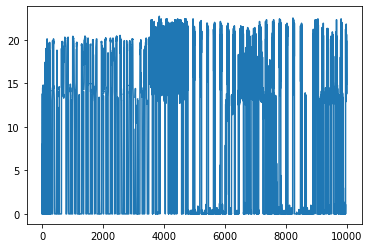

In [ ]:
# The last element contains the labels

# The other data points are the electrocadriogram data
dataframe['SOLAR_VOLT_STATUS'].plot()
data = dataframe['SOLAR_VOLT_STATUS']
data = np.reshape(np.array(data),(100,100))
np.nan_to_num(data,copy=False)
labels = np.ones(100)


train_data, test_data, _, _ = train_test_split(
    data, labels, test_size=0.2, random_state=21
)
print(train_data)

In [ ]:
def create_dataset(df):
  sequences = df
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:

_shape = np.shape(test_data)
train_dataset, seq_len, n_features = create_dataset(train_data)
val_dataset, _, _ = create_dataset(test_data)
test_normal_dataset, _, _ = create_dataset(test_data)
test_anomaly_dataset, _, _ = create_dataset(test_data+ np.random.rand(_shape[0],_shape[1]))

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features,100)
model = model.to(device)

In [ ]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.MSELoss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)

Epoch 1: train loss 8099.65122791063 val loss 10245.98533935547
Epoch 2: train loss 8008.128073120117 val loss 8435.370971679688
Epoch 3: train loss 7949.610012817383 val loss 8282.248364257812
Epoch 4: train loss 7920.067236328125 val loss 8156.51416015625
Epoch 5: train loss 7877.765133666992 val loss 8108.722607421875
Epoch 6: train loss 7857.065057373047 val loss 8078.981494140625
Epoch 7: train loss 7843.625161743164 val loss 8059.076025390625
Epoch 8: train loss 7833.8181640625 val loss 8043.1845703125
Epoch 9: train loss 7826.376843261719 val loss 8031.8072265625
Epoch 10: train loss 7821.167102050781 val loss 8023.343579101563


In [ ]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


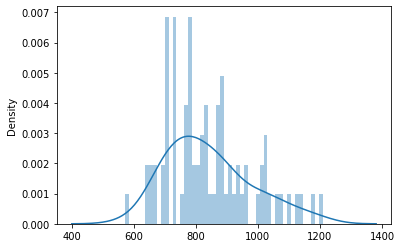

In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 1250

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


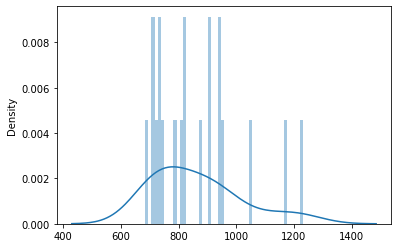

In [ ]:
predictions, pred_losses = predict(model, test_anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'number of normal predictions: {correct}/{len(test_anomaly_dataset)}')

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'number of anomaly predictions: {correct}/{len(test_normal_dataset)}')